In [69]:
import pandas as pd
import numpy as np
import boto3
import dotenv
from dotenv import load_dotenv
import os
import seaborn as sns
from geopy.distance import geodesic
import matplotlib.pyplot as plt

In [70]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df=pd.read_csv('output/corse_Dataset_modele.csv', sep=';', encoding='utf-8', low_memory=False)
  

In [71]:
df.describe(include='all')

,ville,Date,POSTE,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,Code INSEE_x,Code Postal_x,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Département,Code INSEE_y,latitude,longitude,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux,Code Postal_y,Commune
count,257833,257833,2.502340e+05,230522.000000,16945.000000,218823.000000,173411.000000,218746.000000,173457.000000,180425.000000,218326.000000,27070.000000,27101.000000,218326.000000,218326.000000,141191.000000,137404.000000,137151.000000,135057.000000,126478.000000,126382.000000,126324.000000,72792.000000,72066.000000,126651.000000,126219.000000,126644.000000,126155.000000,125152.000000,124932.000000,132467.000000,132602.000000,48770.000000,49469.000000,25454.000000,183059.000000,250234.000000,250234.000000,216423.000000,228448.000000,23634.000000,25304.000000,87315.000000,132826.000000,197467.000000,215211.000000,8906,8906,8906.000000,8906.000000,8.906000e+03,4.008000e+03,5.778000e+03,5.450000e+02,545.000000,545.000000,3.352000e+03,4301.000000,4649,257833.000000,8906,8906
unique,362,7096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,109,350
top,Sisco,2011-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2B,2A004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Malveillance,NaN,20167,AJACCIO
freq,7096,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4553,288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2127,NaN,611,288
mean,NaN,NaN,2.015768e+07,2.454595,63.198289,10.575498,806.368668,19.670751,1181.478505,14.774760,15.144284,8.990007,9.659156,9.099789,15.168166,3.495182,12.333726,195.717756,1179.765543,7.616254,196.449653,1176.264510,12.285790,1186.278925,46.973818,1139.152885,87.982297,1037.371012,106.479944,502.874116,12.217292,69.673368,0.114948,0.039237,3.165424,3.334241,20157.645268,20186.684559,2.456934,2.452635,3.184716,3.171209,3.275598,3.452096,10.803484,10.684589,NaN,NaN,42.200774,9.059919,3.901543e+04,2.061250e+04,2.388798e+04,3.703101e+03,216.513761,170.458716,4.966490e+03,1.322018,NaN,0.034542,NaN,NaN
std,NaN,NaN,9.481819e+04,8.437774,160.865461,6.543977,736.004848,7.655088,220.936203,6.851063,6.833532,6.493232,6.363131,3.888493,6.835036,2.631529,6.497340,99.833508,568.486573,4.284469,101.340692,586.729981,6.483088,608.337335,15.891521,492.210067,10.617517,888.320810,229.875325,426.986976,4.865409,14.208297,0.318962,0.194160,1.981594,2.064249,94.858184,65.331167,0.992707,2.488412,0.432921,1.726082,1.424588,1.706989,2.855854,5.924480,NaN,NaN,0.606483,0.807474,6.455160e+05,5.210895e+05,4.065061e+05,4.840463e+04,3953.881976,2358.968488,7.343132e+04,0.874577,NaN,0.182616,NaN,NaN
min,NaN,NaN,2.000401e+07,0.000000,0.000000,-16.900000,0.000000,-10.900000,0.000000,-13.200000,-13.350000,-10.200000,-38.200000,0.000000,-13.400000,0.000000,1.300000,10.000000,0.000000,0.800000,10.000000,0.000000,2.300000,0.000000,2.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.100000,4.000000,0.000000,0.000000,0.000000,0.000000,20004.000000,20000.000000,0.240000,0.000000,2.310000,0.360000,1.360000,0.440000,2.100000,-7.250000,NaN,NaN,41.387826,-1.680020,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000

In [72]:
# Changement de type de la colonne Feux
df['Feux'] = df['Feux'].astype(int)

In [73]:
# Changement d'emplacement de la colonne Date
cols = [col for col in df.columns if col != 'Date']
cols.append('Date')
df = df[cols]

Pour entraîner notre modèle XGBoost Survival (Cox), nous devons disposer de deux colonnes clés :

une colonne représentant le temps jusqu’à l’événement (durée),

une colonne binaire indiquant si l’événement s’est produit (1) ou non (0).
Nous créons donc également la colonne événement, qui permet de distinguer les cas d’incendie observé des cas censurés.

In [74]:
# Mise en place de la colonne décompte (durée ) avant le feu suivant

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['ville', 'Date'])

def days_until_next_fire(group):
    # Dates où il y a un feu, sinon NaT
    feu_dates = group['Date'].where(group['Feux'] == 1)

    # On inverse la série pour faire un forward fill à rebours (pour chaque date, la prochaine date feu)
    next_feu_dates = feu_dates[::-1].ffill()[::-1]

    # Calcul du delta en jours entre la prochaine date feu et la date actuelle
    delta_days = (next_feu_dates - group['Date']).dt.days

    # Pour les lignes où Feux==1, mettre 0 (par sécurité)
    delta_days[group['Feux'] == 1] = 0

    return delta_days

df['décompte'] = df.groupby('ville').apply(days_until_next_fire).reset_index(level=0, drop=True)

# Création de la colonne évènement pour indiquer si un feu a eu lieu
df['évènement'] = df['Feux'] == 1


/tmp/ipykernel_80438/1588098345.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['décompte'] = df.groupby('ville').apply(days_until_next_fire).reset_index(level=0, drop=True)


In [75]:
df.décompte.isna().sum()

np.int64(100353)

In [76]:
# Modification de l'emplacement du nom de la commune dans le dataset pour plus de lisibilité

cols = list(df.columns)
cols.remove('ville')
new_position = len(cols) - 2
cols.insert(new_position, 'ville')

df = df[cols]


Nous avons des valeurs manquantes en latitude et longitude. Afin de résoudre ce probleme nous avons récupéré toutes les coordonnées GPS des villes de corses

In [77]:
gps=pd.read_csv('https://fireprojectbislead.s3.us-east-1.amazonaws.com/dataset/coordonnees_corses.csv')


In [78]:
df.drop(columns=['POSTE', 'Commune', 'Département', 'latitude', 'longitude','Code INSEE_y'], inplace=True)


In [79]:
df_merge = df.merge(gps, on="ville", how="left")


In [80]:
df_merge.latitude.isna().sum()


np.int64(8181)

Nous avons encore des données manquante en latitude et longitude nous procédons avec un autre ficher.

In [81]:
df_merge = df_merge.rename(columns={'latitude' : 'latitude_y', 'longitude' : 'longitude_y'})


In [82]:

news_gps = pd.read_csv('corse_new_gps.csv')
# on renomme la colonne qui va servir au merge
news_gps = news_gps.rename(columns={'properties.name':'ville'})
# on supprime les colonnes inutiles
news_gps = news_gps.drop(news_gps.columns[[0,1,3]], axis=1)
# Fusionner les deux DataFrames sur la colonne 'ville'
df_combined = df_merge.merge(news_gps, on='ville', how='left', suffixes=('', '_y'))# suffixes=('', '_y')

# Remplacer les valeurs manquantes dans df1 par celles de df2
df_combined['latitude'] = df_combined['latitude_y'].combine_first(df_combined['latitude'])
df_combined['longitude'] = df_combined['longitude_y'].combine_first(df_combined['longitude'])
df_combined.latitude.isna().sum()



np.int64(254)

In [83]:
mask = df_combined['latitude'].isna()
df_missing = df_combined[mask]
df_missing['ville'].unique()

array(['Casanova', 'Costa', 'Guagno', 'Letia', 'Piano',
       'Santo Pietro Di Tenda', 'Vignale'], dtype=object)

Grace à un dernier code nous récupérons les villes manquantes.

In [84]:
!python adress_corse.py


In [85]:
# export du fichier contenant les villes manquantes 
nombre_unique = df_missing['ville']
nombre_unique.to_csv('nombre_unique.csv')

In [86]:
df_unique = pd.read_csv('corse_new_gps2.csv')
df_merge = df_combined.merge(df_unique, on='ville', how='left',suffixes=('', '_y'))
df_merge['latitude'] = df_merge['latitude_x'].combine_first(df_merge['latitude'])
df_merge['longitude'] = df_merge['longitude_y_y'].combine_first(df_merge['longitude'])


In [87]:
df_merge.latitude.isna().sum()

np.int64(156)

In [88]:
df_merge.head()

,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,Code INSEE_x,Code Postal_x,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux,Code Postal_y,Date,ville,décompte,évènement,latitude_y,longitude_y,longitude,latitude,Unnamed: 0,latitude_x,longitude_y_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167,2006-06-09,Afa,0.0,True,NaN,NaN,8.794752,41.977895,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,0.0,0.0,NaN,NaN,NaN,0.0,1.0,Involontaire (travaux),1,20167,2006-06-13,Afa,0.0,True,NaN,NaN,8.794752,41.977895,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,0.0,0.0,NaN,NaN,NaN,0.0,1.0,Involontaire (particulier),1,20167,2006-06-21,Afa,0.0,True,NaN,NaN,8.794752,41.977895,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167,2007-10-04,Afa,0.0,True,NaN,NaN,8.794752,41.977895,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20167,2007-10-09,Afa,0.0,True,NaN,NaN,8.794752,41.977895,NaN,NaN,NaN


In [90]:
print(df_merge['Feux'].value_counts())
# Supprimer les colonnes supplémentaires créées par la fusion
df_merge = df_merge.drop(columns=['latitude_y', 'longitude_y','latitude_x','longitude_y_y', 'Unnamed: 0'])

Feux
0    248927
1      8970
Name: count, dtype: int64


In [91]:
# Création de la colone Feu prévu pour le modèle Survival (True/False)
df_merge.loc[:, "Feu prévu"] = df_merge["décompte"].notna().astype(int)


Création de nouvelles colonnes afin d’enrichir les données et d’améliorer l’apprentissage du modèle de survie.


In [92]:

# S'assurer que la date est bien au bon format
df_merge["Date"] = pd.to_datetime(df_merge["Date"])

# Trier le DataFrame par ville et date
df_merge = df_merge.sort_values(by=["ville", "Date"]).reset_index(drop=True)

# Nouvelle colonne initialisée à NaN
df_merge["compteur jours vers prochain feu"] = pd.NA

# Traitement par ville
for ville, groupe in df_merge.groupby("ville"):
    groupe = groupe.sort_values("Date")
    indices_feux = groupe[groupe["évènement"] == True].index.tolist()
    
    for i in range(len(indices_feux) - 1):
        debut = indices_feux[i]
        fin = indices_feux[i + 1]
        
        # Remplir les jours entre les deux feux avec un compteur croissant
        for j, idx in enumerate(range(debut, fin)):
            df_merge.loc[idx, "compteur jours vers prochain feu"] = j
# # nombre de jour sans feu + log et carré

df_merge['compteur feu log'] = df_merge['compteur jours vers prochain feu'].apply(lambda x: np.log1p(x) if pd.notnull(x) else np.nan)
df_merge['compteur feu carré'] = df_merge['compteur jours vers prochain feu'].apply(lambda x: x**2 if pd.notnull(x) else np.nan)



In [93]:
# # Calcule le nombre de feux par an et mois pour chaque ville
df_merge['Année'] = df_merge['Date'].dt.year
df_merge['Mois'] = df_merge['Date'].dt.month

df_merge['Nombre de feu par an'] = df_merge.groupby(['ville', 'Année'])['Feux'].transform('sum')
df_merge['Nombre de feu par mois'] = df_merge.groupby(['ville', 'Année', 'Mois'])['Feux'].transform('sum')

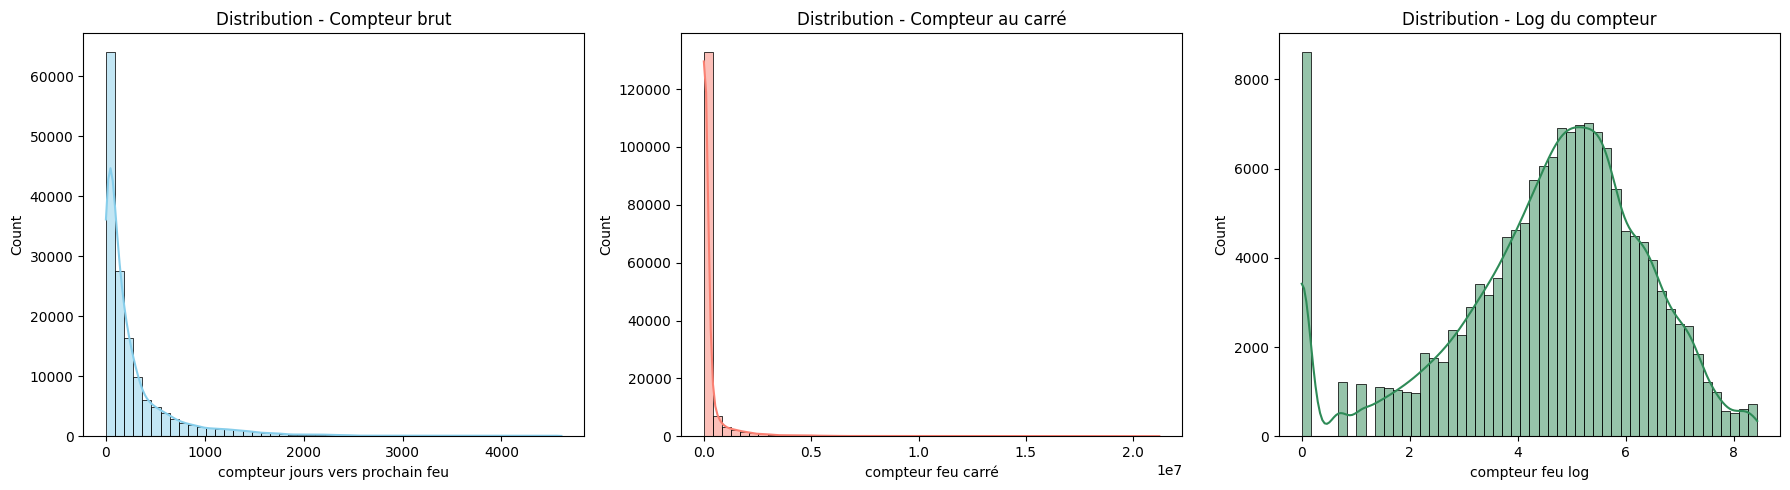

In [94]:
# visualisation
plt.figure(figsize=(18, 5))

# Distribution originale
plt.subplot(1, 3, 1)
sns.histplot(df_merge["compteur jours vers prochain feu"], bins=50, kde=True, color="skyblue")
plt.title("Distribution - Compteur brut")

# Carré
plt.subplot(1, 3, 2)
sns.histplot(df_merge["compteur feu carré"], bins=50, kde=True, color="salmon")
plt.title("Distribution - Compteur au carré")

# Logarithme
plt.subplot(1, 3, 3)
sns.histplot(df_merge["compteur feu log"], bins=50, kde=True, color="seagreen")
plt.title("Distribution - Log du compteur")

plt.tight_layout()
plt.show()

In [95]:

# Trier par ville et par date
df_merge = df_merge.sort_values(['ville', 'Date'])

# Fonction pour compter les jours consécutifs sans pluie
def compter_jours_sans_pluie(groupe):
    compteur = 0
    jours_sans_pluie = []
    for rr in groupe['RR']:
        if pd.isna(rr):
            jours_sans_pluie.append(np.nan)
        elif rr == 0:
            compteur += 1
            jours_sans_pluie.append(compteur)
        else:
            compteur = 0
            jours_sans_pluie.append(compteur)
    return jours_sans_pluie

# Appliquer par ville
df_merge['jours_sans_pluie'] = df_merge.groupby('ville').apply(compter_jours_sans_pluie).explode().astype(float).values

/tmp/ipykernel_80438/3432562024.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge['jours_sans_pluie'] = df_merge.groupby('ville').apply(compter_jours_sans_pluie).explode().astype(float).values


In [96]:

# Fonction pour compter les jours consécutifs avec TX > 30
def compter_jours_chauds(groupe):
    compteur = 0
    jours_chauds = []
    for tx in groupe['TX']:
        if pd.isna(tx):
            jours_chauds.append(np.nan)
        elif tx > 30:
            compteur += 1
            jours_chauds.append(compteur)
        else:
            compteur = 0
            jours_chauds.append(compteur)
    return jours_chauds

# Appliquer la fonction par ville
df_merge= df_merge.sort_values(['ville', 'Date'])  # Assurer l'ordre temporel
df_merge['jours_TX_sup_30'] = df_merge.groupby('ville').apply(compter_jours_chauds).explode().astype(float).values

/tmp/ipykernel_80438/2308045979.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge['jours_TX_sup_30'] = df_merge.groupby('ville').apply(compter_jours_chauds).explode().astype(float).values


In [97]:
# Évapotranspiration Potentielle journalière moyenne sur 7jrs
df_merge["ETPGRILLE_7j"] = df_merge.groupby("ville")["ETPGRILLE"].transform(lambda x: x.rolling(7, min_periods=1).mean())


Certaines zones présentent de nombreuses données météorologiques manquantes. Pour réduire ce problème, nous imputons ces valeurs en utilisant les mesures de la station météo la plus proche, identifiée à l’aide de la librairie geopy (calcul de distances géographiques).

In [98]:

# # Chargement du fichier CSV
# df_merge = pd.read_csv("dataset_modele_decompte2.csv", sep=';', low_memory=False)

# Colonnes météo à compléter
colonnes_meteo = [
    'RR', 'DRR', 'TN', 'HTN', 'TX', 'HTX', 'TM', 'TMNX', 'TNSOL', 'TN50',
    'TAMPLI', 'TNTXM', 'FFM', 'FXI', 'DXI', 'HXI', 'FXY', 'DXY', 'HXY',
    'FXI3S', 'HXI3S', 'UN', 'HUN', 'UX', 'HUX', 'DHUMI40', 'DHUMI80',
    'TSVM', 'UM', 'ORAG', 'BRUME', 'ETPMON', 'ETPGRILLE'
]

# Séparer les lignes avec et sans données météo
df_manquantes = df_merge[df_merge[colonnes_meteo].isnull().any(axis=1)].copy()
df_completes = df_merge.dropna(subset=colonnes_meteo).copy()

# Fonction pour trouver la ville la plus proche avec données météo
def trouver_ville_proche(row, ref_df):
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        return None

    ville_ref = ref_df[['ville', 'latitude', 'longitude']].dropna().drop_duplicates()
    coord = (row['latitude'], row['longitude'])

    ville_ref['distance'] = ville_ref.apply(
        lambda x: geodesic(coord, (x['latitude'], x['longitude'])).km, axis=1
    )

    plus_proche = ville_ref.loc[ville_ref['distance'].idxmin()]
    return plus_proche['ville']

# Associer une ville de référence à chaque ligne manquante
df_manquantes['ville_proche'] = df_manquantes.apply(
    lambda x: trouver_ville_proche(x, df_completes), axis=1
)

# Copier les valeurs météo depuis la ville proche
# Fonction robuste de récupération des données météo
def recuperer_donnees_meteo(row, df_source, max_villes=5):
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        return pd.Series([None] * len(colonnes_meteo), index=colonnes_meteo)

    # Calcul des distances vers toutes les villes avec données météo
    coord = (row['latitude'], row['longitude'])
    villes_ref = df_source[['ville', 'latitude', 'longitude']].dropna().drop_duplicates().copy()

    villes_ref['distance'] = villes_ref.apply(
        lambda x: geodesic(coord, (x['latitude'], x['longitude'])).km, axis=1
    )

    # Trier par proximité
    villes_proches = villes_ref.sort_values('distance').head(max_villes)

    # Chercher une ville avec données pour cette date
    for _, ville_row in villes_proches.iterrows():
        ville = ville_row['ville']
        meme_jour = df_source[
            (df_source['ville'] == ville) & (df_source['Date'] == row['Date'])
        ]
        if not meme_jour.empty:
            return meme_jour[colonnes_meteo].iloc[0]

    # Si aucune ville ne convient
    return pd.Series([None] * len(colonnes_meteo), index=colonnes_meteo)



# Appliquer proprement les remplacements
for idx, row in df_manquantes.iterrows():
    valeurs_remplacement = recuperer_donnees_meteo(row, df_completes)
    for col in colonnes_meteo:
        if pd.isna(df_manquantes.at[idx, col]) and pd.notna(valeurs_remplacement[col]):
            df_manquantes.at[idx, col] = valeurs_remplacement[col]


# Fusion des deux ensembles pour un dataframe complet
df_final = pd.concat([
    df_completes,
    df_manquantes
]).sort_index()




In [ ]:
df_final.to_csv('output/dataset_modele_decompte2.csv', index=False, sep=';')